In [2]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as albu
import argparse
import time
import cv2
from torch import nn
from tqdm import tqdm

In [3]:
os.chdir('..')
%pwd

'C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection'

In [4]:
def denormalize(image, preprocessing_fn):
    """From image in [0,1] to [0,255] according to preprocessing function"""
    image = image * torch.tensor(preprocessing_fn.keywords['std']).view(-1,1,1) + torch.tensor(preprocessing_fn.keywords['mean']).view(-1,1,1)
    return image

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    input : 
        - preprocessing_fn : preprocessing function
    output :
        - transform : albumentations object
    """
    return albu.Lambda(image=preprocessing_fn)

def resize(input_size, deform="rectangular"):
    """Transformation for validation set
    input : 
        - input_size : integer for resizing maximum side
    output :
        - transform : albumentations object
    """
    if deform=="square":
        transform = albu.Resize(input_size, input_size)
    elif deform=="scale":
        transform = albu.LongestMaxSize(input_size)
    elif deform=="rectangular":
        transform = albu.Resize(input_size[0], input_size[1])
    else:
        print("deform argument unknown")
        
    return transform

In [5]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [63]:
# argument parser
input_dir  = "C:\\Temp\\data\\video_image_1"
output_dir = "C:\\Temp\\data\\mask_image_1"
model_dir  = "C:\\Users\\gueganj\\Desktop\\Eyeglasses Detection\\prediction"
    
# size to downsample image as in training
input_size = (544,960)

# Load Model
#model = torch.load(os.path.join(model_dir,'model_frame.ckpt'),map_location=device)
model = smp.Unet(encoder_name="mobilenet_v2",  encoder_weights='imagenet', activation='sigmoid')
model.segmentation_head[0] = nn.Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
checkpoint = torch.load(os.path.join(model_dir,'checkpoint'),map_location=device)
model.load_state_dict(checkpoint[0])
model.eval()
model.to(device)
print()

In [64]:
# Normalize image
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet18", 'imagenet')

list_image = glob.glob(os.path.join(input_dir,'*.jpg'))
if not list_image:
    print("ERROR : no image found in input")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

torch.Size([1, 3, 544, 960]) tensor(2.6400)


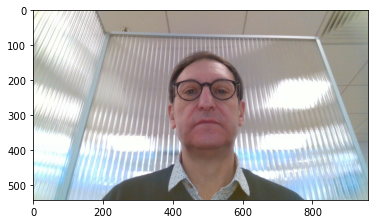

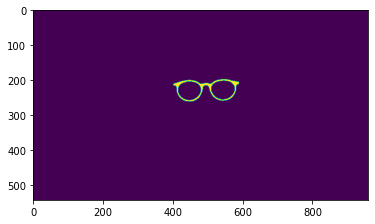

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


In [73]:
for image_name in tqdm(list_image[:1]):
    # read
    image = np.array(Image.open(image_name))
    # resize
    sample = resize(input_size)(image=image)
    # apply normalization
    sample = get_preprocessing(preprocessing_fn)(image=sample['image'])
    # transform to tensor format
    image = torch.Tensor(sample['image'].transpose(2, 0, 1).astype('float32')).unsqueeze(0)
    print(image.size(),image.max())
    # prediction
    with torch.no_grad():
        proba = model.forward(image)
        prediction = proba > 0.5
    # format for segmentation display (currently only 1 class)
    image = denormalize(image.squeeze(), preprocessing_fn)
    image = image.permute(1,2,0).numpy()
    image_mean = np.mean(image,axis=2)
    image_mean = np.repeat(image_mean[:, :, np.newaxis], 3, axis=2)
    image_mean[prediction.squeeze()] = [1,0,0]
    image_mean[image_mean<0]=0
    plt.imshow(image),plt.show()
    plt.imshow(proba.squeeze()),plt.show()
    # save and display
    #plt.imsave(os.path.join(output_dir,os.path.basename(image_name)),image_mean)
    #plt.imsave(os.path.join(output_dir,os.path.basename(image_name).replace('.jpg','.png')),prediction.squeeze())

In [29]:
# create video

In [31]:
image_folder = 'C:\\Temp\\data\\video_prediction_7'
video_name   = 'C:\\Temp\\data\\video_prediction_7.avi'
# get image
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape
# create video object
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (width,height))
for i, image in enumerate(tqdm(images)):
    image_read = cv2.imread(os.path.join(image_folder, str(i)+".jpg"))
    video.write(image_read)
    #time.sleep(0.001)

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 328/328 [00:08<00:00, 39.47it/s]


In [53]:
x = torch.tensor([[[1,2]], [[2,3]], [[3,4]]])
x.size()

torch.Size([3, 1, 2])

In [54]:
x.max()

tensor(4)